In [1]:

from src.NNs.Dataset import SimpleAxonDataset, TiledAxonDataset, AugmentedAxonDataset, GIGAAugmentedAxonDataset
from src.NNs.Unet import UNetModel
from src.NNs.training import train_and_save_Unet

import os
import random
import numpy as np

import torch
from datetime import datetime



from src.NNs.Dataset import SimpleAxonDataset, TiledAxonDataset, AugmentedAxonDataset, GIGAAugmentedAxonDataset
from src.NNs.Unet import UNetModel, SmallUNetModel, SuperSmallUNetModel
from src.NNs.training import train_and_save_Unet
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from datetime import datetime


In [2]:
import sys
from torch.nn import BCELoss, BCEWithLogitsLoss
from transformers import get_cosine_schedule_with_warmup

c:\Users\Ethier Lab\anaconda3\envs\antoine_axones\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.append("../")
from clDice.cldice_loss.pytorch.cldice import soft_cldice, soft_dice_cldice

In [4]:
train_dataset_path = r".\data\tracings\rat301_train"
from src.dataprep.TracingChecker import TracingChecker
TracingChecker(train_dataset_path).check()

test_dataset_path = r".\data\tracings\rat301_test"
from src.dataprep.TracingChecker import TracingChecker
TracingChecker(test_dataset_path).check()

EPOCHS = 50
EPOCHS_DISPLAY = 5
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
num_workers = 0
device = "cuda" if torch.cuda.is_available() else "cpu"


----------------------------------------
Checking labeled dataset at path .\data\tracings\rat301_train
1: 0 missing image samples | []
2: 0 missing tracings | []
3: 0 missing channels | {}
4: 0 missing masks | []
5: 0 missing info.txt files | []
----------------------------------------
Checking labeled dataset at path .\data\tracings\rat301_test
1: 0 missing image samples | []
2: 0 missing tracings | []
3: 0 missing channels | {}
4: 0 missing masks | []
5: 0 missing info.txt files | []


In [5]:
input_size = 128
tiled_split_step = 128
aug_split_step = 128
thiccness = 3
experiment_charactersitic_string = "thick_axons_connected_loss"
test_dataset = SimpleAxonDataset(test_dataset_path, input_size=input_size)
train_datasets = [SimpleAxonDataset(train_dataset_path, input_size=input_size, axon_thiccness=thiccness),
                    TiledAxonDataset(train_dataset_path, input_size=input_size, split_step=tiled_split_step, axon_thiccness=thiccness),
                    AugmentedAxonDataset(train_dataset_path, input_size=input_size, split_step=aug_split_step, axon_thiccness=thiccness),
                    GIGAAugmentedAxonDataset(train_dataset_path, input_size=input_size, split_step=aug_split_step, axon_thiccness=thiccness)
]


train_dataset_names = ["SimpleDataset", "TiledDataset", "AugDataset", "GIGAAugmented"]
model_types = [UNetModel, UNetModel, UNetModel, UNetModel]
date_str = datetime.now().strftime("%Y-%m-%d")
model_paths = [ f"trained_models/{date_str}_{d}_{experiment_charactersitic_string}.pth" for d in train_dataset_names]

In [6]:
# n_repeats = 2
# experiment_charactersitic_string = "thick_axons_connected_loss_repeat"
# test_dataset = SimpleAxonDataset(test_dataset_path, input_size=input_size)
# 
# train_datasets = [AugmentedAxonDataset(train_dataset_path, input_size=input_size, split_step=aug_split_step, axon_thiccness=thiccness) for _ in range(n_repeats)]
# train_dataset_names = ["AugDataset" for _ in range(n_repeats)]
# model_types = [UNetModel for _ in range(n_repeats)]

date_str = datetime.now().strftime("%Y-%m-%d")
# model_paths = [ f"trained_models/{date_str}_{d}_{experiment_charactersitic_string}.pth" for d in train_dataset_names]
alpha = 0.4
smooth = 0.0

In [7]:
# for train_dataset, model_type, d in zip(train_datasets, model_types, train_dataset_names):
#     path = f"trained_models/{date_str}_{d}_{experiment_charactersitic_string}_{alpha}_{smooth}.pth"
#     print(f"Training {path} with alpha {alpha} and smooth {smooth}")
#     criterion = soft_dice_cldice(iter_=10, alpha = alpha, smooth=smooth)
#     train_and_save_Unet(train_dataset,test_dataset, EPOCHS, model_type, path, criterion,
#                         lr = LEARNING_RATE, batch_size = BATCH_SIZE, n_epochs_display=EPOCHS_DISPLAY, display_loss=True, make_schedular_function=get_cosine_schedule_with_warmup)

In [8]:
# for alpha in [0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1.0]:
#     for smooth in [0.0, 1.1]:
#         for train_dataset, model_type, d in zip(train_datasets, model_types, train_dataset_names):
#             path = f"trained_models/{date_str}_{d}_{experiment_charactersitic_string}_{alpha}_{smooth}.pth"
#             print(f"Training {path} with alpha {alpha} and smooth {smooth}")
#             criterion = soft_dice_cldice(iter_=10, alpha = alpha, smooth=smooth)
#             train_and_save_Unet(train_dataset,test_dataset, EPOCHS, model_type, path, criterion,
#                                 lr = LEARNING_RATE, batch_size = BATCH_SIZE, n_epochs_display=EPOCHS_DISPLAY, display_loss=True)
# Best params = alpha 0.3 and smooth 0.0, AugmentedAxonDataset tends to be better

c:\Users\Ethier Lab\Desktop\AJ\AxonSurvey\src\NNs\inference.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.dev

DICE coefficient: 0.49065


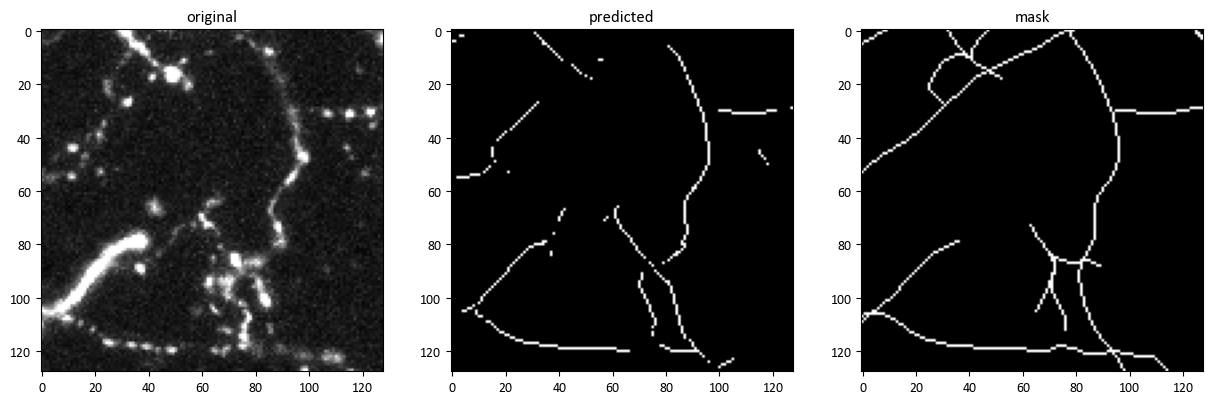

DICE coefficient: 0.52956


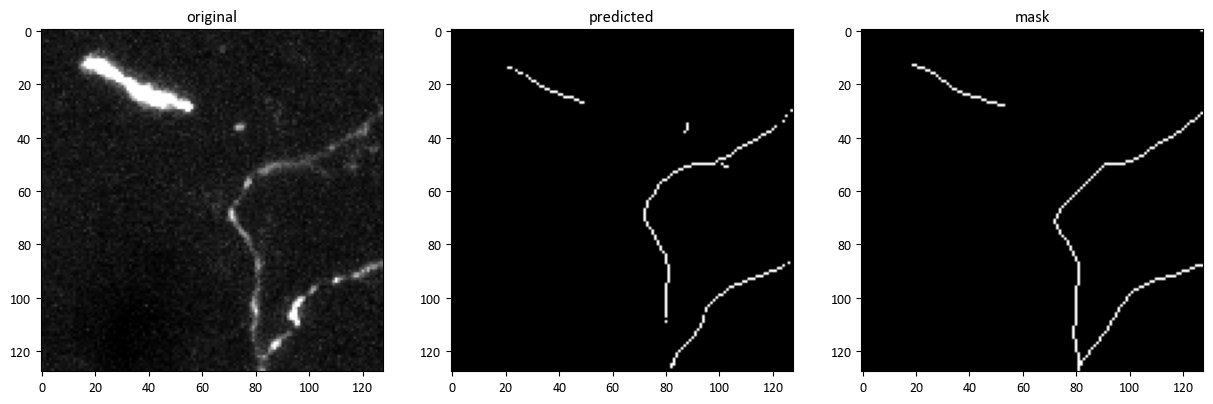

DICE coefficient: 0.59144


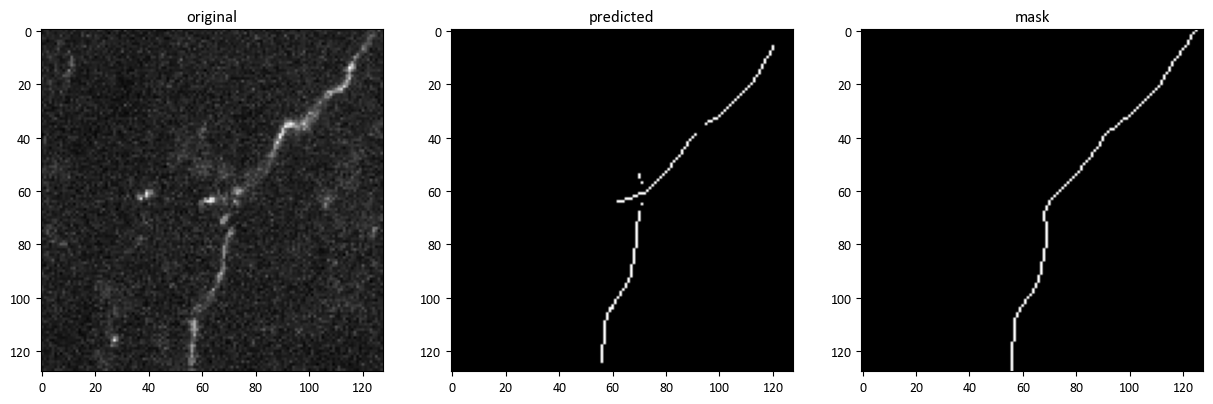

DICE coefficient: 0.6129


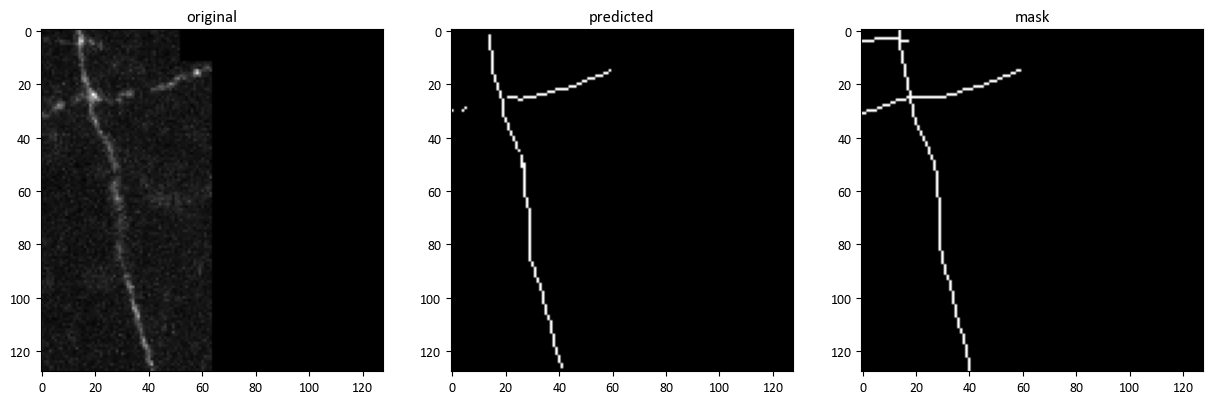

DICE coefficient: 1.0


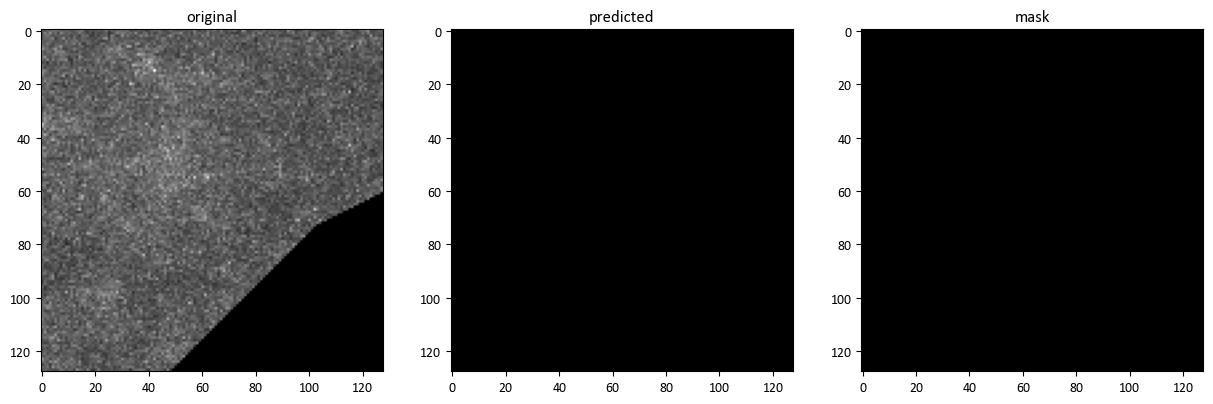

DICE coefficient: 1.0


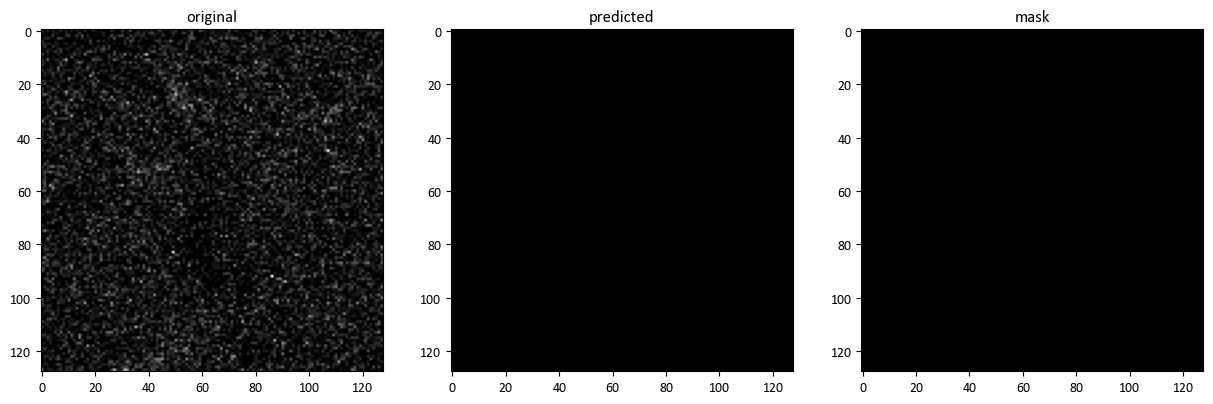

DICE coefficient: 0.57699


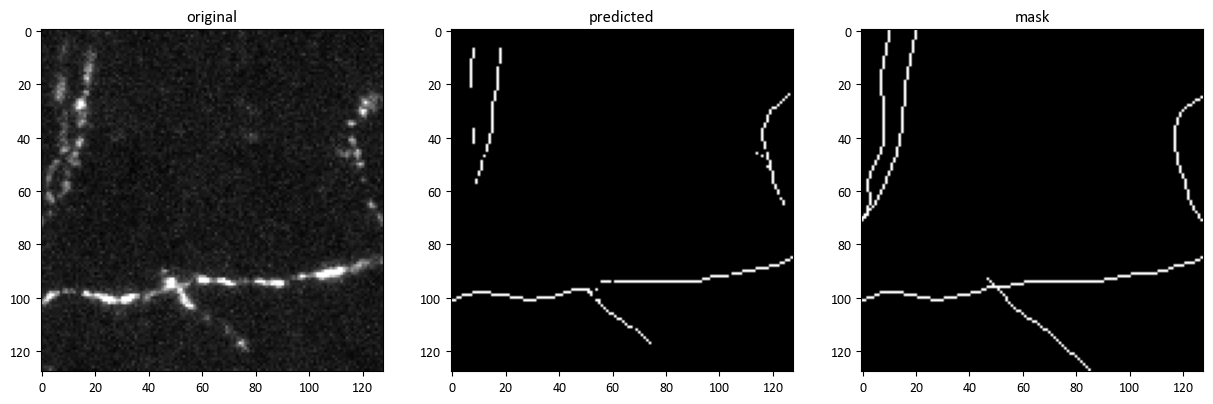

DICE coefficient: 0.22798


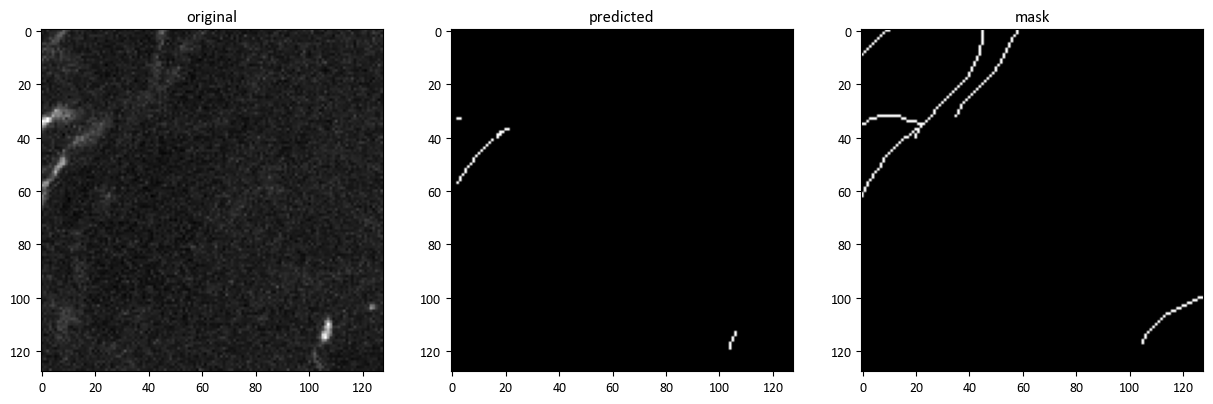

DICE coefficient: 0.30508


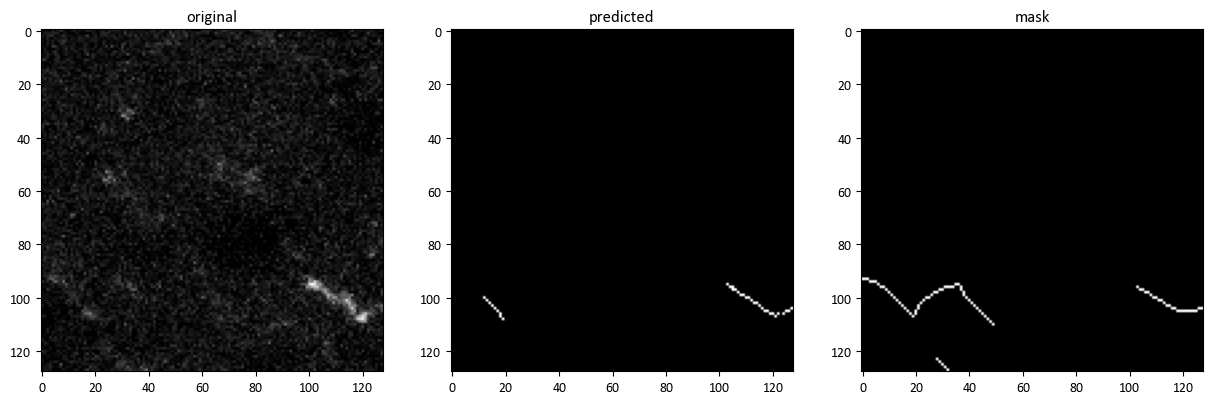

DICE coefficient: 0.59694


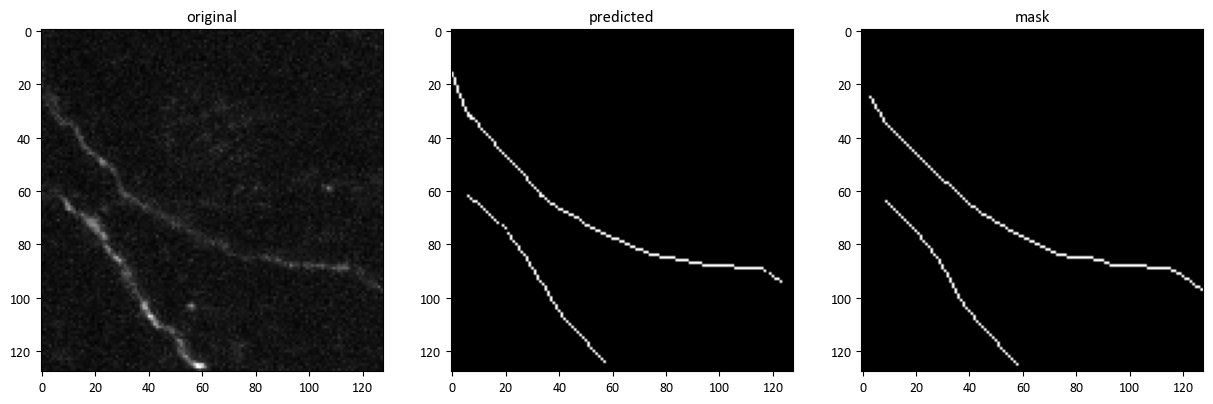

In [9]:
from src.NNs.viz import random_images_inference
n_images = 10
mpath = "./trained_models/basic_trainings/2025-06-06_GIGAAugmented_200ep.pth"
random_images_inference(n_images, test_dataset_path, mpath, UNetModel, dataset_type=SimpleAxonDataset)

In [10]:
from src.NNs.viz import random_images_inference
n_images = 10
for mpath, mtype, in zip(model_paths, model_types):
    random_images_inference(n_images, test_dataset_path, mpath, mtype, dataset_type=SimpleAxonDataset)

FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/2025-07-30_SimpleDataset_thick_axons_connected_loss.pth'